In [201]:
# Important necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.lines import Line2D
from tqdm import *
from itertools import compress
from scipy.optimize import bisect
%matplotlib inline  

In [202]:
def combine_background_files(folder='../data/bkg_Zj/', lumi=37*1000, nfiles=200, cut=None):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]*5000
        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    return data

In [203]:
def to_str(num):
    if .2 <= num <= .9:
        return '{:.1g}'.format(num)[-2:]
    elif num == 0:
        return '0.0'
    elif num == 0.99:
        return '0.99'
    elif num == 1:
        return '1.0'
    else:
        return str(num)

def combine_signal_files(folder='../data/bkg_Zj/', mphi = 1700, rinv = 1, lumi=37*1000, nfiles=4, cut = None,extra='', return_cxn = False):
    """ Read .evt and .meta files as output by monojet.C and 
        properly weigh events
    """
    
    evt_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.evt', header=0, delimiter=',', skipinitialspace=True) for i in range(nfiles)]
    good_frames = np.array([len(evt_frame) for evt_frame in evt_frames]) > 0
    
    evt_frames = list(compress(evt_frames, good_frames))
    meta_frames = [pd.read_csv(folder+'events_'+str(extra)+str(mphi)+"_"+to_str(rinv)+"_"+str(i)+'.meta', header=0, delimiter=',', skipinitialspace=True) for i in compress(range(nfiles),good_frames)]
    sum_weights = np.sum([meta_frame['sum_weight'] for meta_frame in meta_frames])
    mean_cxn  = np.mean([meta_frame['cxn'] for meta_frame in meta_frames])
    for evt_frame, meta_frame in zip(evt_frames, meta_frames):
        evt_frame['weight'] *= (meta_frame['cxn']*lumi/sum_weights)[0]


        
    data = pd.concat(evt_frames)
    
    if cut is not None:
        data = data.query(cut)
    if return_cxn:
        return data, mean_cxn
    else:
        return data

# Background distributions

In [377]:
Zj_df = combine_background_files('../data/bkg_Zj/', nfiles=200)
Wj_df = combine_background_files('../data/bkg_Wj/', nfiles=200)
tt_d_df = combine_background_files('../data/bkg_ttbar_dilep//', nfiles=200)
tt_s_df = combine_background_files('../data/bkg_ttbar_semilep//', nfiles=200)
QCD_df = combine_background_files('../data/bkg_qcd//', nfiles=600)

tt_df = pd.concat([tt_d_df, tt_s_df])
ewk_df = pd.concat([Zj_df, Wj_df])

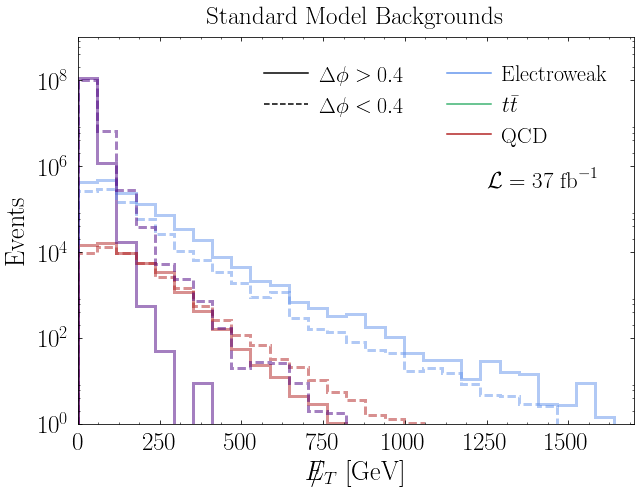

In [406]:
title = "Standard Model Backgrounds"

bins = np.linspace(0,1700,30)
normed = False
fig=plt.figure(figsize=(9,7))
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'dphi > 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colors[0])

# plt.hist(Wj_df.query(cut)['MEt'], weights=Wj_df.query(cut)['weight'], 
#                      bins=bins,
#                      histtype='step', alpha=.5, lw=3, label="$W+j$", normed=normed, color=plot_colors[1])

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colors[2])

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colors[3])

cut = 'dphi < 0.4'

plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[0], ls='--')

# plt.hist(ewk_df.query(cut)['MEt'], weights=ewk_df.query(cut)['weight'], 
#                      bins=bins,
#                      histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[1], ls='--')

plt.hist(tt_df.query(cut)['MEt'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3,  normed=normed, color=plot_colors[2], ls='--')

plt.hist(QCD_df.query(cut)['MEt'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, normed=normed, color=plot_colors[3], ls='--')

plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=26)

plt.ylim(1e0,1e9)
ax = plt.gca()

plt.title(title, fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


handles,labels = ax.get_legend_handles_labels()
handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i]) for i in range(3)] #, handles[2]]
labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)
plt.xlim(0,1700)
plt.text(1250,3*10**5,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)

plt.tick_params(axis='both', which='major', labelsize=25)

plt.ylabel("Events",fontsize = 26)
plt.yscale("log")
plt.tight_layout()
plt.savefig("BkgsMET.pdf")

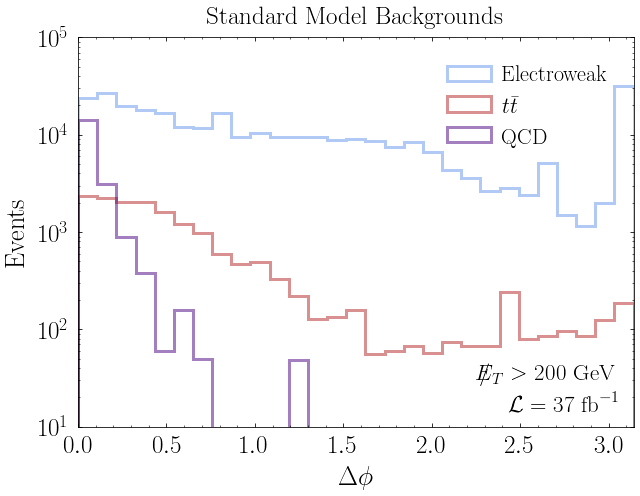

In [407]:
bins = np.linspace(0,np.pi,30)
normed = False
fig=plt.figure(figsize=(9,7))
plot_colors=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
cut = 'MEt > 200'

plt.hist(ewk_df.query(cut)['dphi'], weights=ewk_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="Electroweak", normed=normed, color=plot_colors[0])

# plt.hist(Wj_df.query(cut)['dphi'], weights=Wj_df.query(cut)['weight'], 
#                      bins=bins,
#                      histtype='step', alpha=.5, lw=3, label="$W+j$", normed=normed, color=plot_colors[1])

plt.hist(tt_df.query(cut)['dphi'], weights=tt_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="$t\\bar t$", normed=normed, color=plot_colors[2])

plt.hist(QCD_df.query(cut)['dphi'], weights=QCD_df.query(cut)['weight'], 
                     bins=bins,
                     histtype='step', alpha=.5, lw=3, label="QCD", normed=normed, color=plot_colors[3])


plt.ylim(10,1e5)
ax = plt.gca()

plt.title(title, fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])



handles,labels = ax.get_legend_handles_labels()
# handles = [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i]) for i in range(4)] #, handles[2]]
# labels = [r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$',"","",labels[0],labels[1],labels[2],labels[3]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel("$\Delta\phi$",fontsize=26)
plt.tight_layout()
plt.ylabel("Events",fontsize=26)
plt.yscale("log")
plt.xlim(0,np.pi)
plt.text(2.43,14,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)
plt.text(2.25,28,"$\slash \!\!\!\! E_{T} >$ 200 GeV",fontsize=23)
plt.tight_layout()
plt.savefig("BkgsDphi.pdf")

# Contact operator distributions

In [423]:
rinvs = [.00, .3, .6, 1.0 ]

sig10 = [ combine_signal_files('../data//sig_zprime//', 100000, rinv,nfiles=12) for rinv in rinvs  ]
cxn10 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv ,return_cxn=True,nfiles=12)[1] for rinv in rinvs ]

sig100 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv,nfiles=12, extra = '100_') for rinv in rinvs  ]
cxn100 = [ combine_signal_files('../data/sig_zprime/', 100000, rinv,nfiles=12, extra = '100_',return_cxn=True)[1] for rinv in rinvs  ]

In [424]:
plot_color=['cornflowerblue','mediumseagreen', 'firebrick','indigo','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']

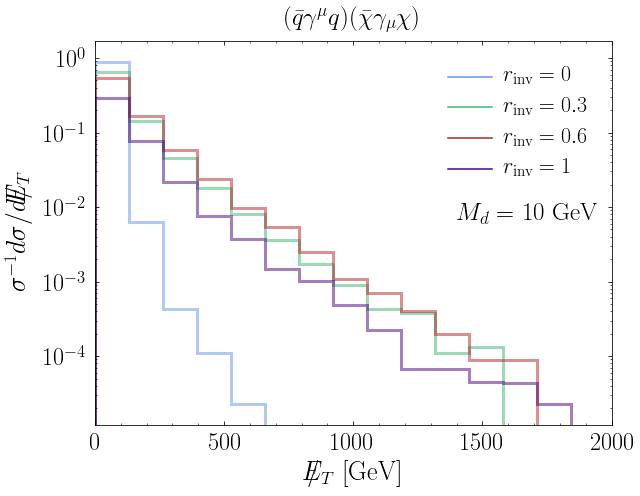

In [425]:
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"

lumi = 37000
bins = bins=np.linspace(0,2500,20)
fig=plt.figure(figsize=(9,7))

for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv]['MEt'], weights=sig10[irinv]['weight'].values/cxn10[irinv]/lumi, lw=3, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)
    plt.hist(sig100[irinv]['MEt'], weights=sig100[irinv]['weight'].values/cxn100[irinv]/lumi, lw=0, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=26)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\slash \!\!\!\! E_{T}}$',fontsize=26)  
plt.xlim([0,2000])


plt.title(title, fontsize=25)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [Line2D([],[],color='k',lw=0)] + [Line2D([],[],color='k',ls='--',lw=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i]) for i in range(4)] #, handles[2]]
labels = ["","","","",labels[0],labels[2],labels[4],labels[6]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.text(1400, 0.006, "$M_d$ = 10 GeV",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=24)

plt.tight_layout()
plt.savefig("met_sig.pdf")

In [426]:
# from PIL import Image
# Image.open('met_sig.png').convert('LA')

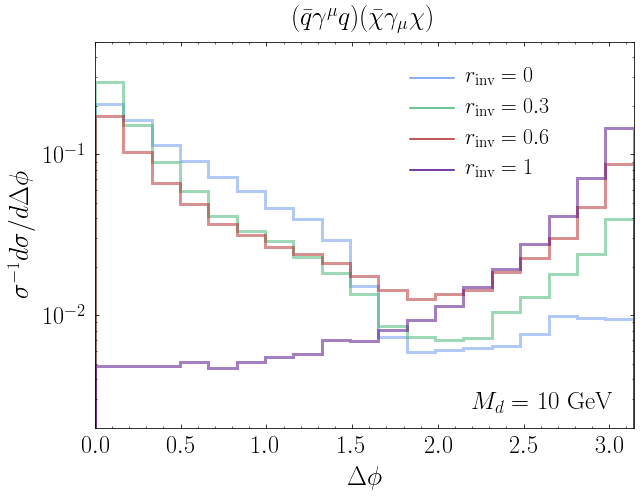

In [431]:
lumi = 37000
bins = bins=np.linspace(0,np.pi,20)
fig=plt.figure(figsize=(9,7))

cut = 'MEt > 0'
for irinv, rinv in enumerate(rinvs):
    plt.hist(sig10[irinv].query(cut)['dphi'], weights=sig10[irinv].query(cut)['weight'].values/cxn10[irinv]/lumi, lw=3.0, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)
    plt.hist(sig100[irinv].query(cut)['dphi'], weights=sig100[irinv].query(cut)['weight'].values/cxn100[irinv]/lumi, lw=0, ls = '--', label="$r_{\\rm inv}=%0.2g$" % rinv, histtype='step', color=plot_color[irinv],alpha=.5, bins=bins)


    
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\Delta\phi$',fontsize=26)
plt.ylabel(r'${\sigma^{-1}d\sigma/d\Delta\phi$',fontsize=26)  
plt.xlim([0,np.pi])
# plt.ylim(10**0,10**3)

plt.title(title, fontsize=26)
ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

handles,labels = ax.get_legend_handles_labels()
handles = [Line2D([],[],color='k',lw=0)] + [Line2D([],[],color='k',ls='--',lw=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i],alpha=0)] + [Line2D([],[],color=plot_color[i]) for i in range(4)] #, handles[2]]
labels = ["","","","",labels[0],labels[2],labels[4],labels[6]] #, labels[2]]
leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.86, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)

plt.text(2.2, 0.0025, "$M_d$ = 10 GeV",fontsize=25)
plt.ylim(0.002,0.5)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.savefig("dphi_sig.pdf")

## UV-completion distributions

In [277]:
# make histograms
def newfig(name):
    fig=plt.figure(name,figsize=(9,7))
    plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

    
def plot_met_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")

    cell.hist(sig['MEt'], weights=fudge*sig['weight'].values, 
             bins=np.linspace(0,2500,20),
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,2500])
    cell.set_yscale('log', nonposy='clip')

def plot_dphi_cell(cell, sig, lw=3, ls='solid', label="temp", fudge=1., **kwargs):
    newfig("met")

    cell.hist(sig['dphi'], weights=fudge*sig['weight'].values, 
             bins=np.linspace(0,np.pi,20),
             histtype='step',alpha=.5, lw=1.6, linestyle=ls,
             label=label, **kwargs)
    cell.set_xlim([0,np.pi])
    cell.set_yscale('log', nonposy='clip')



# plot_color=['forestgreen','cornflowerblue', 'maroon','goldenrod','violet','maroon','darkgrey','lightpink','black','forestgreen','cornflowerblue', 'salmon','violet','goldenrod','maroon','darkgrey','lightpink']
plot_ls=['solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid','solid']

In [278]:
rinvs = [0.00,.3,.6, 1.0]
# rinvs = [1.0]


masses = [500, 1000, 2000, 3000, 5000, 10000]
# masses = [3000,5000,10000,20000,50000,100000]

3it [00:03,  1.24s/it]


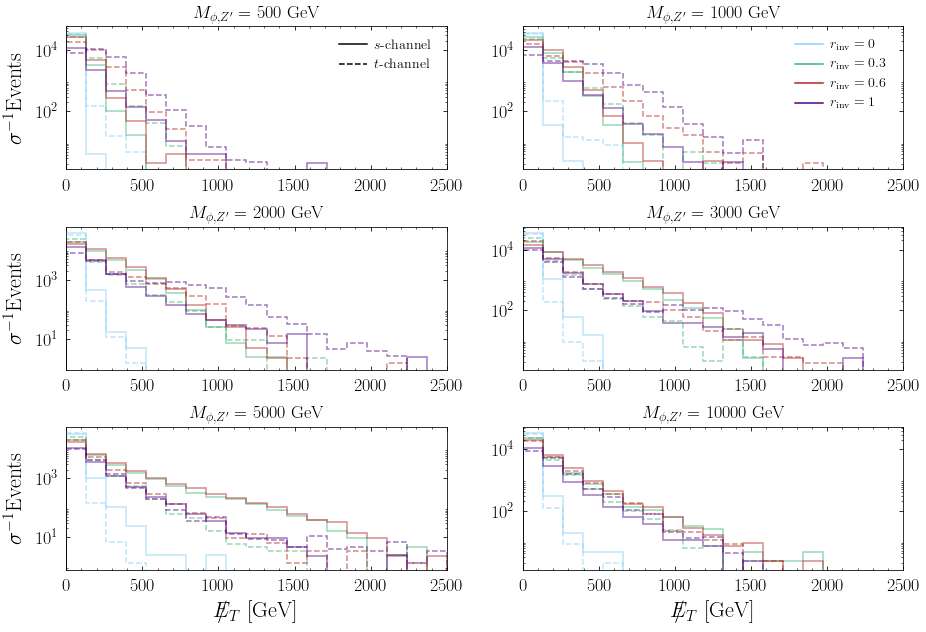

In [279]:
fig, axes2d = plt.subplots(nrows=3, ncols=2,
                           figsize=(15,10))


for i, row in tqdm(enumerate(axes2d)):
    for j, cell in enumerate(row):
        M = masses[i*2 + j]
        
        sig10 = [ combine_signal_files('../data/sig_zprime//', M, rinv) for rinv in rinvs  ]
        cxn10 = [ combine_signal_files('../data/sig_zprime/', M, rinv,return_cxn=True)[1] for rinv in rinvs  ]
        sig10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv) for rinv in rinvs  ]
        cxn10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv,return_cxn=True)[1] for rinv in rinvs  ]
        
        for irinv, rinv in enumerate(rinvs):
            plot_met_cell(cell, sig=sig10[irinv], lw=2, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, fudge=1/cxn10[irinv], color=plot_color[irinv])
            plot_met_cell(cell, sig=sig10_tch[irinv], lw=2, ls = '--', label=str(rinv), fudge=1/cxn10_tch[irinv], color=plot_color[irinv])
        
        if i*2 + j in range(4,6):
            cell.set_xlabel(r'$\slash \!\!\!\! E_{T}$ [GeV]',fontsize=22)
        if (i*2 + j) % 2 == 0:
            cell.set_ylabel(r'$\sigma^{-1}{\rm Events}$',fontsize=22)

        if (i*2 + j) == 0:
            handles = [Line2D([],[],color='k',ls='solid'), Line2D([],[],color='k',ls='--')]
            labels = ["$s$-channel","$t$-channel"] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=14, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)



        if (i*2 + j) == 1:
            handles,labels = cell.get_legend_handles_labels()
            handles = [Line2D([],[],color=plot_color[i]) for i in range(4)] #, handles[2]]
            labels = [labels[0], labels[2],labels[4],labels[6]] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=14, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


#             cell.legend(title="rinv")
            
        cell.set_title("$M_{\phi,Z^{\prime}} = $ "+str(M)+" GeV")

fig.subplots_adjust(wspace=.2, hspace=.4)
# plt.tight_layout()
fig.savefig("tChMETTotal.pdf")

3it [00:01,  1.56it/s]


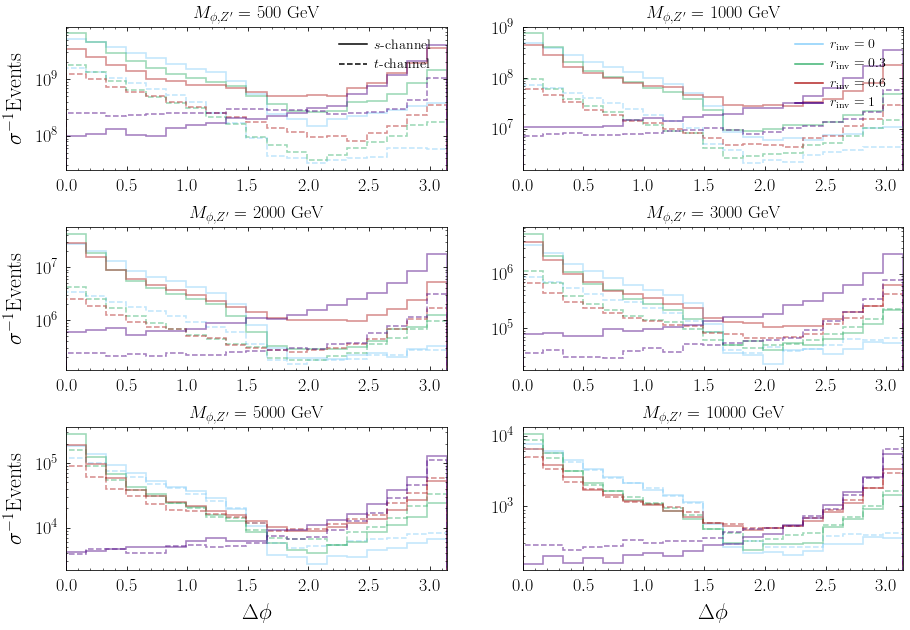

In [280]:
fig, axes2d = plt.subplots(nrows=3, ncols=2,
                           figsize=(15,10))


for i, row in tqdm(enumerate(axes2d)):
    for j, cell in enumerate(row):
        M = masses[i*2 + j]
        
        sig10 = [ combine_signal_files('../data/sig_zprime/', M, rinv) for rinv in rinvs  ]
        sig10_tch = [ combine_signal_files('../data/sig_tchannel/', M, rinv) for rinv in rinvs  ]
        
        for irinv, rinv in enumerate(rinvs):
            plot_dphi_cell(cell, sig=sig10[irinv], lw=2, ls = 'solid', label="$r_{\\rm inv}=%0.2g$" % rinv, fudge=1/cxn10[irinv], color=plot_color[irinv])
            plot_dphi_cell(cell, sig=sig10_tch[irinv], lw=2, ls = '--', label=str(rinv), fudge=1/cxn10_tch[irinv], color=plot_color[irinv])
        
        if i*2 + j in range(4,6):
            cell.set_xlabel(r'$\Delta\phi$',fontsize=22)
        if (i*2 + j) % 2 == 0:
            cell.set_ylabel(r'$\sigma^{-1}{\rm Events}$',fontsize=22)

        if (i*2 + j) == 0:
            handles = [Line2D([],[],color='k',ls='-'), Line2D([],[],color='k',ls='--')]
            labels = ["$s$-channel","$t$-channel"] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=14, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)



        if (i*2 + j) == 1:
            handles,labels = cell.get_legend_handles_labels()
            handles = [Line2D([],[],color=plot_color[i]) for i in range(4)] #, handles[2]]
            labels = [labels[0], labels[2],labels[4],labels[6]] #, labels[2]]
            leg = cell.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=14, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


#             cell.legend(title="rinv")
            
        cell.set_title("$M_{\phi,Z^{\prime}} = $ "+str(M)+" GeV")

fig.subplots_adjust(wspace=.2, hspace=.4)
# plt.tight_layout()
fig.savefig("tChdphiTotal.pdf")

# Contact limits

In [281]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.02**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

In [282]:
bkgs = [Zj_df, Wj_df, tt_d_df, tt_s_df, QCD_df]

In [283]:
def get_bkg(bkg, cut=None):
    if cut is not None:
        new_bkg = bkg.query(cut)
    else: 
        new_bkg = bkg
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

def get_sig(sig, cut=None):
    if cut is not None:
        new_bkg = sig.query(cut)
    else: 
        new_bkg = sig
    return np.sum(np.histogram(new_bkg['MEt'].values, weights=new_bkg['weight'].values)[0])

In [284]:
cutlist=[]
basecut = 'pt1 > 0 & '

for MEtcut in [400,600,800,100,1200]:
    for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
        c1 = 'MEt > ' + str(MEtcut) + ' & '
        cutlist =  cutlist + [basecut + c1 + dphicut ]

In [285]:
bkg_list= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist) ] 

100%|██████████| 10/10 [00:00<00:00, 31.60it/s]


In [400]:
masses = [100000]
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [401]:
cxn10 = [ combine_signal_files('../data/sig_zprime////', 100000, rinv, extra = 'coup1_w10' , nfiles=1, return_cxn=True)[1] for rinv in rinvs ]
cxn100 = [ combine_signal_files('../data/sig_tchannel_old///////', 100000, rinv, extra = '', nfiles=1,return_cxn=True)[1] for rinv in rinvs  ]

In [402]:
np.mean(cxn10)/np.mean(cxn100)

38.674884048567044

In [403]:
cxn10 = [ combine_signal_files('../data/sig_zprime///', 100000, rinv, extra = '' , nfiles=16, return_cxn=True)[1] for rinv in rinvs ]
cxn100 = [ combine_signal_files('../data/sig_zprime////', 100000, rinv, extra = '100_', nfiles=16,return_cxn=True)[1] for rinv in rinvs  ]

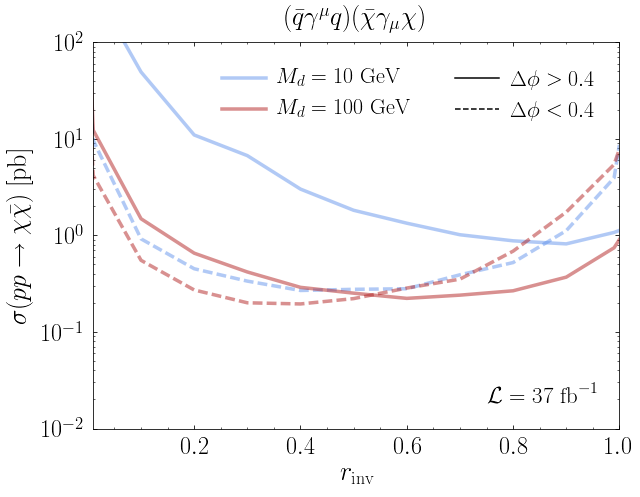

In [410]:
newfig("exc")
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime////", mphi = 100000, rinv = r, extra = '', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)


plt.plot(rinvs, result_less*cxn10, lw=3.5, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn10, lw=3.5,
                 color='cornflowerblue', label=r'$M_d = 10 ~\mathrm{GeV}$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime/////", mphi = 100000, rinv = r,extra = '100_', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

plt.plot(rinvs, result_less*cxn100, lw=3.5, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, result_gtr*cxn100, lw=3.5,
                 color='firebrick', label=r'$M_d = 100 ~\mathrm{GeV}$',alpha=.5)



plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=26)
plt.ylabel(r'$\sigma(pp \rightarrow \chi \bar\chi) \;[{\rm pb}]$',fontsize=26)
plt.xlim([0.01,1.0])
plt.ylim([1e-2, 1e2])
plt.title(title, fontsize=26)


plt.legend(loc='upper right',
           fontsize=20, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=24)
# ax.set_yticklabels(ticklabels)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_color[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)




ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)

plt.text(.75,.018,"$\mathcal L = 37~\mathrm{fb}^{-1}$",fontsize=23)


plt.tight_layout()
plt.savefig("ContactXsecLims.pdf")




plt.show()

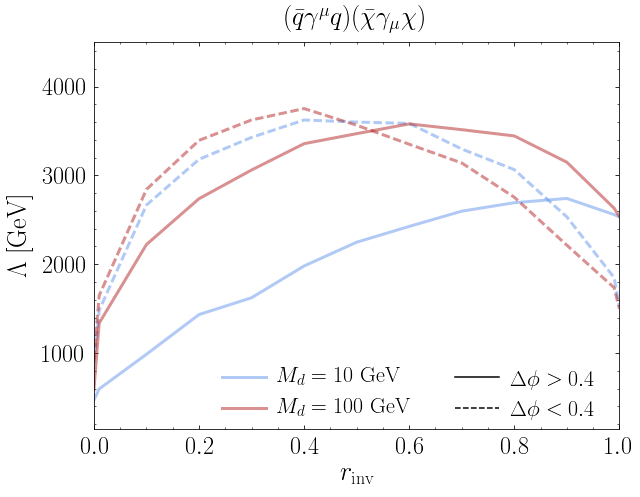

In [411]:
newfig("exc")
cutoff = 100000
title = "$(\\bar q \gamma^\mu q)(\\bar \chi \gamma_\mu \chi)$"


result_less=np.zeros([len(rinvs)])
result_gtr=np.zeros([len(rinvs)])

cutindex_less=np.zeros([len(rinvs)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs)],dtype=int)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime////", mphi = 100000, rinv = r, extra = '', nfiles=16);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)
    
contact_less = cutoff/(result_less)**(1/4.)/np.sqrt(0.1)
contact_gtr = cutoff/(result_gtr)**(1/4.)/np.sqrt(0.1)

plt.plot(rinvs, contact_less, lw=3, ls='--',
                 color='cornflowerblue',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, contact_gtr, lw=3,
                 color='cornflowerblue', label=r'$M_d = 10 ~\mathrm{GeV}$',alpha=.5)


for ir,r in enumerate(rinvs):

    sig = combine_signal_files("../data/sig_zprime//////", mphi = 100000, rinv = r,extra = '100_', nfiles=12);
    tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi < 0.4' in cut])
    tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list[i]) for i,cut in enumerate(cutlist) if 'dphi > 0.4' in cut])
    result_less[ir]=np.amin(tempresult_less)
    result_gtr[ir]=np.amin(tempresult_gtr)

    cutindex_less[ir]=np.argmin(tempresult_less)
    cutindex_gtr[ir]=np.argmin(tempresult_gtr)

plt.plot(rinvs, cutoff/(result_less)**(1/4.)/np.sqrt(0.1), lw=3, ls='--',
                 color='firebrick',  label=r'$\Delta \phi < 0.4$',alpha=.5)
plt.plot(rinvs, cutoff/(result_gtr)**(1/4.)/np.sqrt(0.1), lw=3,
                 color='firebrick', label=r'$M_d = 100 ~\mathrm{GeV}$',alpha=.5)

# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=26)
plt.ylabel(r'$\Lambda$ [GeV]',fontsize=26)
plt.xlim([0.0,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=26)


plt.legend(loc='upper right',
           fontsize=20, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=24)
# ax.set_yticklabels(ticklabels)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# handles = [Line2D([],[],color=plot_color[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=22, ncol=2,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)




# ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)

plt.ylim(150,4500)
plt.tight_layout()
plt.savefig("ContactLambdaLims.pdf")




plt.show()

# t-channel scan

In [541]:
bkgs = [Zj_df, Wj_df, tt_d_df, tt_s_df, QCD_df]

In [542]:
cutlist=[]
basecut = 'pt1 > 250 & '

# for MEtcut in [400, 600, 800]:
#     for pt2cut in [0]:
#         for HTcut in [0]:
#             for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
#                 c1 = 'MEt > ' + str(MEtcut) + ' & '
#                 c2 = 'pt2 > ' + str(pt2cut) + ' & '
#                 c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
#                 cutlist =  cutlist + [basecut + c1 + c2 + c3 + dphicut ]
         
cutlist=[]
basecut = 'pt1 > 0 & '        
for MEtcut in [600,800]:
    for pt2cut in [0]:
        for HTcut in [0]:
            for dphicut in ['dphi < 0.4', 'dphi > 0.4']:
                c1 = 'MEt > ' + str(MEtcut) + ' & '
                c2 = 'pt2 > ' + str(pt2cut) + ' & '
                c3 = 'pt1 + pt2 + pt3 + pt4 > ' + str(HTcut) + ' & '
                cutlist =  cutlist + [basecut + c1 + c2 + c3 + dphicut ]

In [543]:
def limit(sig,bkg):
    if np.sum(sig)==0:
        return 1e99
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.02**2*qcd_1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    
    soln = bisect(func_root, -10.,20.)
    return 10**soln

In [544]:
masses = np.arange(500,2500,100)
rinvs = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

In [545]:
cutlist_gtr = [cut for cut in cutlist if 'dphi > 0.4' in cut]
cutlist_less = [cut for cut in cutlist if 'dphi < 0.4' in cut]

In [546]:
bkg_list_gtr= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist_gtr) ] 
bkg_list_less= [np.sum([get_bkg(bkg, cut) for bkg in bkgs]) for cut in tqdm(cutlist_less) ] 

100%|██████████| 2/2 [00:00<00:00, 20.97it/s]


In [547]:
sig = combine_signal_files("../data/sig_tchannel_old///", mphi = m, rinv = r);
print np.array([ limit(get_sig(sig, 'MEt > 1300'),bkg_list_less[i]) for i,cut in enumerate(cutlist_less) ])

[ 13.82273749   5.2132538 ]


In [548]:
sig = combine_signal_files("../data/sig_tchannel///", mphi = m, rinv = r);
print np.array([ limit(get_sig(sig, 'MEt > 1300'),bkg_list_less[i]) for i,cut in enumerate(cutlist_less) ])

[ 19.20833137   7.22939025]


In [549]:
result_less=np.zeros([len(rinvs),len(masses)])
result_gtr=np.zeros([len(rinvs),len(masses)])

cutindex_less=np.zeros([len(rinvs),len(masses)],dtype=int)
cutindex_gtr=np.zeros([len(rinvs),len(masses)],dtype=int)


for im,m in tqdm(enumerate(masses)):
    for ir,r in enumerate(rinvs):
        
        sig = combine_signal_files("../data/sig_tchannel/////", mphi = m, rinv = r,nfiles=8);
        tempresult_less=np.array([ limit(get_sig(sig, cut),bkg_list_less[i]) for i,cut in enumerate(cutlist_less) ])
        tempresult_gtr=np.array([ limit(get_sig(sig, cut),bkg_list_gtr[i]) for i,cut in enumerate(cutlist_gtr) ])
#         print("{:1.2f}, {:d}, {:1.3f}".format(r,m,np.amin(tempresult)))
#         print (tempresult_less, tempresult_gtr)


        result_less[ir, im]=np.amin(tempresult_less)
        result_gtr[ir, im]=np.amin(tempresult_gtr)
        
#         print len(tempresult_less), len(tempresult_gtr)

        cutindex_less[ir, im]=np.argmin(tempresult_less)
        cutindex_gtr[ir, im]=np.argmin(tempresult_gtr)
        
#         print("optimal cut l: ",cutlist_less[cutindex_less[ir,im]])
#         print("optimal cut g: ",cutlist_gtr[cutindex_gtr[ir,im]])



20it [00:24,  1.19s/it]


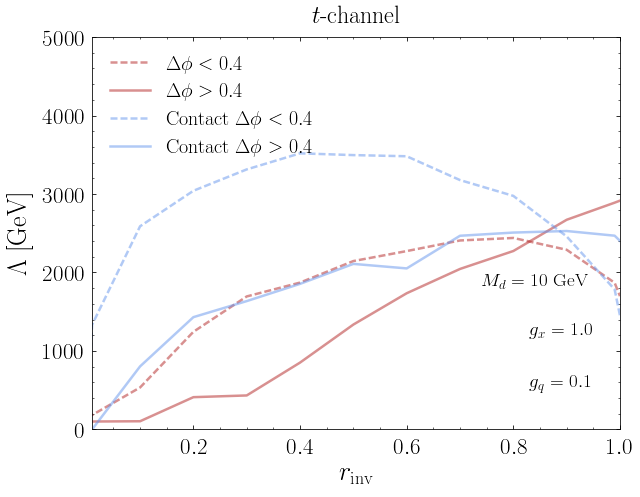

In [553]:
from scipy.optimize import fsolve
newfig("exc")
title='$t$-channel'

mass_limit_less=np.zeros(len(rinvs))
mass_limit_gtr=np.zeros(len(rinvs))


for i,r in enumerate(rinvs):
    mymass = np.insert(masses,0,0)
    masslist_less = np.insert(result_less[i],0,0)
    masslist_gtr = np.insert(result_gtr[i],0,0)    
    mass_limit_less[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_less), 2)[0]
    mass_limit_gtr[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_gtr), 2)[0]


plt.plot(rinvs,np.sqrt(2)*mass_limit_less, label = r'$\Delta \phi < 0.4$',alpha=.5,lw=2.5, color='firebrick', ls='--')
plt.plot(rinvs,np.sqrt(2)*mass_limit_gtr, label = r'$\Delta \phi > 0.4$',alpha=.5,lw=2.5, color='firebrick')

plt.plot(rinvs,contact_less, label = r'Contact $\Delta \phi < 0.4$',alpha=.5,lw=2.5, ls='--', color='cornflowerblue')
plt.plot(rinvs,contact_gtr, label = r'Contact  $\Delta \phi > 0.4$',alpha=.5,lw=2.5, color='cornflowerblue')


# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=26)
plt.ylabel(r'$\Lambda$ [GeV]',fontsize=26)
plt.xlim([0.01,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=24)


plt.legend(loc='upper left',
           fontsize=20, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=23)
# ax.set_yticklabels(ticklabels)

# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# # handles = [Line2D([],[],color=plot_color[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
# labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

# leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
#            fontsize=20, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0.)

ax.set_ylim(0,5000)

# ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)


ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


plt.text(.74,9200-7400, "$M_d = 10$ GeV", fontsize = 19)
plt.text(.83,8570-7400, "$g_x = 1.0$", fontsize = 19)
plt.text(.83,7900-7400, "$g_q = 0.1$", fontsize = 19)

# ax = plt.axes()
# ax.arrow(.36,8450, 0., -400, head_width=0.01, head_length=80, fc='k', ec='k')
# # plt.text(.20,7850,"Exclusion",fontsize=17)

# ax2 = ax.twinx()

# ax2.set_ylabel("$M_\phi$ [GeV]", rotation=270,labelpad=35)

# ax2.plot(rinvs, mass_limit_less, ls='--',lw=0)
# ax2.set_ylim(0,2500)

# plt.xlim(0.0,1)

# plt.tight_layout()

# plt.tick_params(axis='both', which='major', labelsize=23)

# plt.ylim(0,5000)
plt.tight_layout()
plt.savefig("tChannelLims.pdf")




plt.show()



# s-channel limits

In [173]:
mass_lims_schannel = [    0.      ,     980.56156249 , 3327.41646839 , 3672.88945312 , 3751.77360285,
  3623.8715439   , 3386.04270153 , 2937.37777449 , 2402.56258518  , 999.97841573,
     0.    ,         0.        ,     0.        ]

In [174]:
mass_lims_dijets_schannel = [ 3088.10052123 , 3028.37356425 , 2663.24622078 , 22536299935  ,1887.8149791,
  1480.83838644  ,   0.      ,       0. ,            0.        ,     0.      ,       0.,
     0.       ,      0.        ]

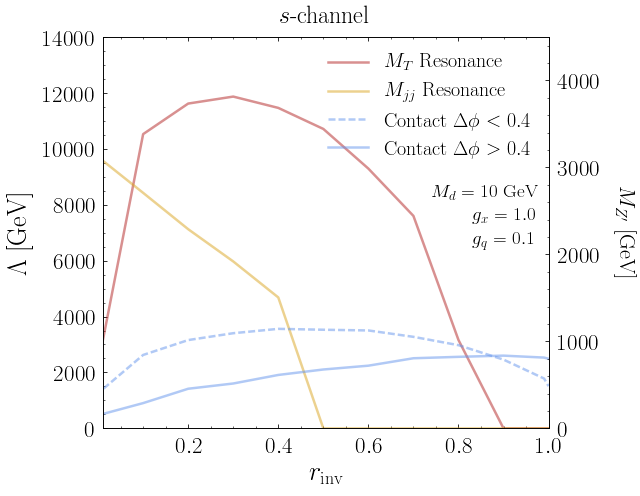

In [184]:
from scipy.optimize import fsolve
newfig("exc")
title='$s$-channel'

# mass_limit_less=np.zeros(len(rinvs))
# mass_limit_gtr=np.zeros(len(rinvs))


# for i,r in enumerate(rinvs):
#     mymass = np.insert(masses,0,0)
#     masslist_less = np.insert(result_less[i],0,0)
#     masslist_gtr = np.insert(result_gtr[i],0,0)    
#     mass_limit_less[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_less), 2.)[0]
#     mass_limit_gtr[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist_gtr), 2.)[0]


# final_limit=mass_limit
# print(mass_limit)


# final_limit[0]=0
# final_limit[1]=0
# cutoff = final_limit/np.sqrt(.1)
plt.plot(rinvs,mass_lims_schannel/np.sqrt(0.1), label = r'$M_T$ Resonance',alpha=.5,lw=2.5, color='firebrick', ls='-')
plt.plot(rinvs,mass_lims_dijets_schannel/np.sqrt(0.1), label = r'$M_{jj}$ Resonance',alpha=.5,lw=2.5, color='goldenrod', ls='-')


# plt.plot(rinvs,mass_lims_schannel/np.sqrt(0.1), label = r'$\Delta \phi > 0.4$',alpha=.5,lw=2.5, color='firebrick')

plt.plot(rinvs,contact_less, label = r'Contact $\Delta \phi < 0.4$',alpha=.5,lw=2.5, ls='--', color='cornflowerblue')
plt.plot(rinvs,contact_gtr, label = r'Contact  $\Delta \phi > 0.4$',alpha=.5,lw=2.5, color='cornflowerblue')


# plt.yscale('log', nonposy='clip')
plt.xlabel(r'$r_{\rm inv}$',fontsize=26)
plt.ylabel(r'$\Lambda$ [GeV]',fontsize=26)
plt.xlim([0.01,1.0])
# plt.ylim([0, 5000])

plt.title(title, fontsize=24)


plt.legend(loc='upper right',
           fontsize=20, ncol=1,frameon=False, fancybox=True)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

# ticklabels = ["$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$"]

plt.tick_params(axis='both', which='major', labelsize=23)
# ax.set_yticklabels(ticklabels)

# handles,labels = ax.get_legend_handles_labels()
# handles = [handles[i] for i in [1,3]] + [Line2D([],[],color='k')]  + [Line2D([],[],color='k',ls='--')] #, handles[2]]
# # handles = [Line2D([],[],color=plot_color[i]) for i in [1,3,5]] + [Line2D([],[],color='k')] + [Line2D([],[],color='k',ls='--')] #, handles[2]] + 
# labels = [labels[1], labels[3],r'$\Delta \phi > 0.4$',r'$\Delta \phi < 0.4$'] #, labels[2]]

# leg = plt.legend(handles,labels,bbox_to_anchor=(0, 0, 0.97, 0.95),
#            fontsize=20, ncol=2,frameon=False,
#            handletextpad=.5,
#            borderaxespad=0.)

ax.set_ylim(0,14000)

# ax = plt.axes()
# ax.arrow(0.62, 0.8, 0., 0.2, head_width=0.01, head_length=0.1, fc='k', ec='k')
# plt.text(.64,.5,"Exclusion",fontsize=18)


ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])


plt.text(.74,9200-1000, "$M_d = 10$ GeV", fontsize = 19)
plt.text(.83,8370-1000, "$g_x = 1.0$", fontsize = 19)
plt.text(.83,7500-1000, "$g_q = 0.1$", fontsize = 19)

ax = plt.axes()
# ax.arrow(.36,8450, 0., -400, head_width=0.01, head_length=80, fc='k', ec='k')
# plt.text(.20,7850,"Exclusion",fontsize=17)

ax2 = ax.twinx()

ax2.set_ylabel("$M_{Z'}$ [GeV]", rotation=270,labelpad=35)

ax2.plot(rinvs, mass_lims_schannel, ls='--',lw=0)
ax2.set_ylim(0,4500)

plt.xlim(0.01,1)

plt.tight_layout()

plt.tick_params(axis='both', which='major', labelsize=23)

# plt.ylim(0,3000)
plt.tight_layout()
plt.savefig("sChannelLims.pdf")




plt.show()




In [159]:
import os
masses_rename = list(np.arange(500,3500,500))+[5000,10000]
rinvs_rename = [0.0, 0.01,0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.99, 1.0]

base_dir = "/group/hepheno/smsharma/Dark-Showers/data/sig_tchannel/hepmc/"

for mass in tqdm(masses_rename):
    for rinv in tqdm(rinvs_rename):
        for inum in range(3):
            os.system("mv " + base_dir + "events_hepmc_M" + str(mass) + "_rinv" + to_str(rinv) +"_"+str(inum) + " " + base_dir +"/events_hepmc_M" + str(mass) + "_rinv" + str(rinv) +"_"+str(inum)+".hepmc")

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


# Number of dark hadrons

In [417]:
lambdaa = 0.01
Nc=2
NFf=2
NBf=0

b = 11./3 *Nc - 1./6. * NBf - 2./3. * NFf

def alphad(lambdaa):
    return 2*np.pi / (b*np.log(1000/lambdaa))

In [418]:
alphad(100)

0.45479211794728036

In [419]:
alphad(10)

0.22739605897364018

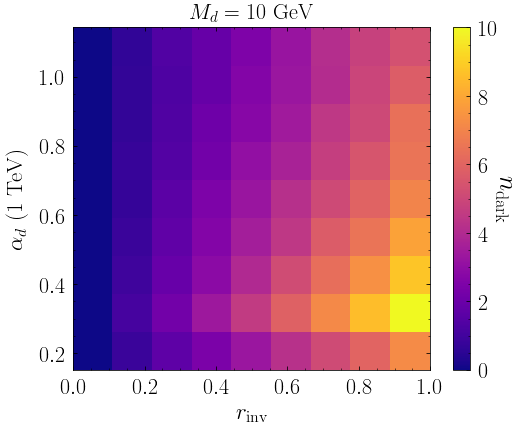

In [420]:
lambda_range = np.linspace(1, 400, 10)
rinv_range = np.linspace(0,1,10)
nmeson = np.zeros((len(lambda_range),len(rinv_range)))

for ilambda, lambdo in enumerate(lambda_range):
    for irinv,rinv in enumerate(rinv_range):
        nmeson[ilambda,irinv] =np.mean(pd.read_csv("../gen/out_" + str(lambdo) + "_"+ str(rinv)[:5]+".evt", header=0, delimiter=',', skipinitialspace=True)['n_meson'])
#         print nmeson[irinv, ilambda] 
# fig=plt.figure(figsize=(8,6.3))
fig, ax = plt.subplots(figsize=(8,6.3))
a = np.nan_to_num(nmeson[:-1, :-1])
N = 10
Y, X = np.mgrid[alphad(1):alphad(400):complex(0, N), 0:1:complex(0, N)]


plt.pcolor(X, Y,a/2,cmap='plasma', vmin=0, vmax=10)
plt.xlabel("$r_\mathrm{inv}$", fontsize=23)
plt.ylabel("$\\alpha_d$ (1 TeV)", fontsize=23)
cbar = plt.colorbar()
axis = plt.gca()
# axis.set_aspect('equal') # X scale matches Y scale
# plt.text( .8, .22,"fds", fontsize=22)
plt.title("$M_d = 10$ GeV", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label(label="$n_\mathrm{dark}$", fontsize=26, rotation=270, labelpad = 15)
plt.savefig("ndmesons_md10.pdf")
plt.show()





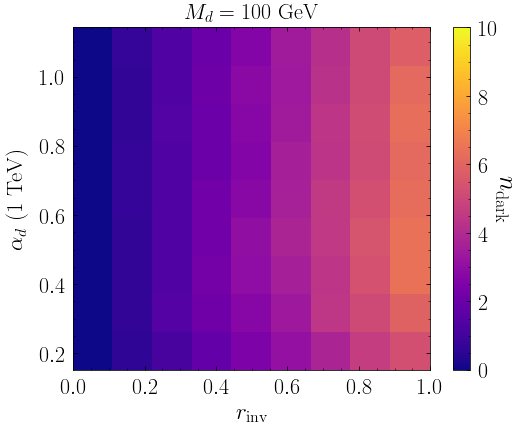

In [421]:
lambda_range = np.linspace(1, 400, 10)
rinv_range = np.linspace(0,1,10)
nmeson = np.zeros((len(lambda_range),len(rinv_range)))

for ilambda, lambdo in enumerate(lambda_range):
    for irinv,rinv in enumerate(rinv_range):
        nmeson[ilambda,irinv] =np.mean(pd.read_csv("../gen/out_100_" + str(lambdo) + "_"+ str(rinv)[:5]+".evt", header=0, delimiter=',', skipinitialspace=True)['n_meson'])
#         print nmeson[irinv, ilambda] 
# fig=plt.figure(figsize=(8,6.3))
fig, ax = plt.subplots(figsize=(8,6.3))
a = np.nan_to_num(nmeson[:-1, :-1])
N = 10
Y, X = np.mgrid[alphad(1):alphad(400):complex(0, N), 0:1:complex(0, N)]


plt.pcolor(X, Y,a/2,cmap='plasma', vmin=0, vmax=10)
plt.xlabel("$r_\mathrm{inv}$", fontsize=23)
plt.ylabel("$\\alpha_d$ (1 TeV)", fontsize=23)
cbar = plt.colorbar()
axis = plt.gca()
# axis.set_aspect('equal') # X scale matches Y scale
# plt.text( .8, .22,"fds", fontsize=22)
plt.title("$M_d = 100$ GeV", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label(label="$n_\mathrm{dark}$", fontsize=26, rotation=270, labelpad = 15)
plt.savefig("ndmesons_md100.pdf")
plt.show()






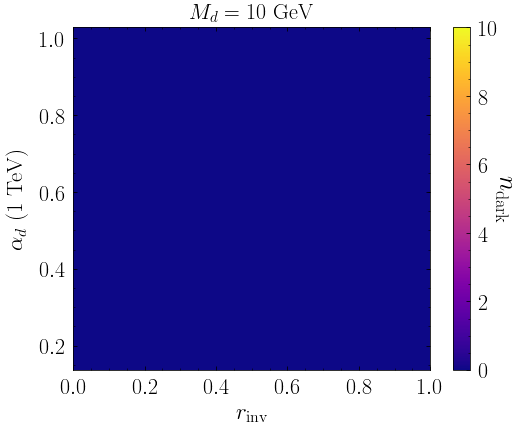

In [416]:
lambda_range = np.linspace(1, 400, 10)
rinv_range = np.linspace(0,1,10)
nmeson = np.zeros((len(lambda_range),len(rinv_range)))

for ilambda, lambdo in enumerate(lambda_range):
    for irinv,rinv in enumerate(rinv_range):
        nmeson[ilambda,irinv] =np.mean(pd.read_csv("../gen/out_100_" + str(lambdo) + "_"+ str(rinv)[:5]+".evt", header=0, delimiter=',', skipinitialspace=True)['n_glu'])
#         print nmeson[irinv, ilambda] 
# fig=plt.figure(figsize=(8,6.3))
fig, ax = plt.subplots(figsize=(8,6.3))
a = np.nan_to_num(nmeson[:-1, :-1])
N = 10
Y, X = np.mgrid[alphad(1):alphad(400):complex(0, N), 0:1:complex(0, N)]


plt.pcolor(X, Y,a/2,cmap='plasma', vmin=0, vmax=10)
plt.xlabel("$r_\mathrm{inv}$", fontsize=23)
plt.ylabel("$\\alpha_d$ (1 TeV)", fontsize=23)
cbar = plt.colorbar()
axis = plt.gca()
# axis.set_aspect('equal') # X scale matches Y scale
# plt.text( .8, .22,"fds", fontsize=22)
plt.title("$M_d = 10$ GeV", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label(label="$n_\mathrm{dark}$", fontsize=26, rotation=270, labelpad = 15)
# plt.savefig("ndmesons_md10.pdf")
plt.show()






In [422]:
239/255., 0 , 247/255.

(0.9372549019607843, 0, 0.9686274509803922)

In [433]:
print 1.000000000000454

1.0
